In [2]:
import pandas as pd

#loading the datasets
movies_df = pd.read_csv(r'C:\Users\FEMI\Documents\DSF PROJECTS\Section 1 Phase 4\REFINED PROJECT\Movie-Recommendation-System-Group_12-Project\Data\ml-latest-small\movies.csv')
links = pd.read_csv(r'C:\Users\FEMI\Documents\DSF PROJECTS\Section 1 Phase 4\REFINED PROJECT\Movie-Recommendation-System-Group_12-Project\Data\ml-latest-small\links.csv')
ratings = pd.read_csv(r'C:\Users\FEMI\Documents\DSF PROJECTS\Section 1 Phase 4\REFINED PROJECT\Movie-Recommendation-System-Group_12-Project\Data\ml-latest-small\ratings.csv')
tags = pd.read_csv(r'C:\Users\FEMI\Documents\DSF PROJECTS\Section 1 Phase 4\REFINED PROJECT\Movie-Recommendation-System-Group_12-Project\Data\ml-latest-small\tags.csv')


In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


REMOVING MISSING VALUES

In [7]:
print(movies_df.isnull().sum())
print(ratings.isnull().sum())
print(tags.isnull().sum())
print(links.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
movieId    0
imdbId     0
tmdbId     8
dtype: int64


Checking for duplicates

In [8]:
print(movies_df.duplicated().sum())
print(ratings.duplicated().sum())
print(tags.duplicated().sum())
print(links.duplicated().sum())

0
0
0
0


EDA

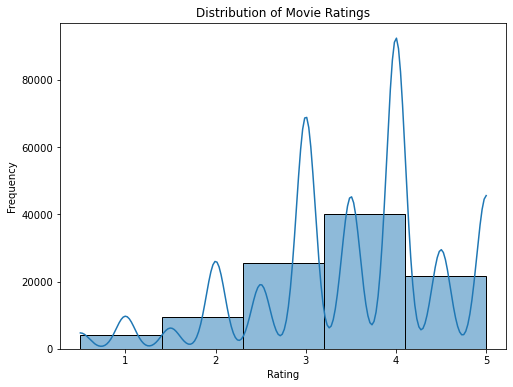

In [9]:
#loading the necessary libraries
import matplotlib.pyplot as plt   
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(ratings['rating'], bins=5, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

MOVIE RATINGS

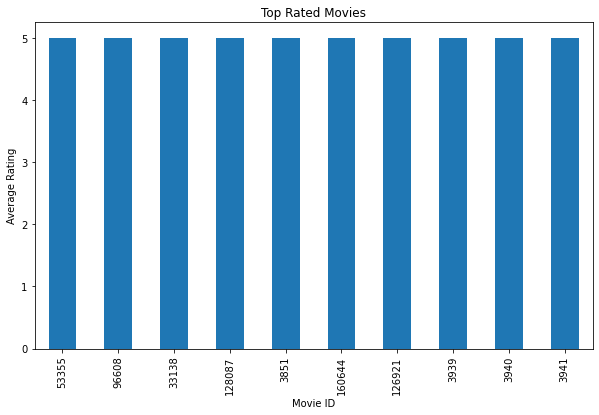

In [10]:
# Average rating per movie
average_ratings = ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False)

# Plot the top 10 highest-rated movies
plt.figure(figsize=(10, 6))
average_ratings.head(10).plot(kind='bar')
plt.title('Top Rated Movies')
plt.xlabel('Movie ID')
plt.ylabel('Average Rating')
plt.show()


Checking correlation

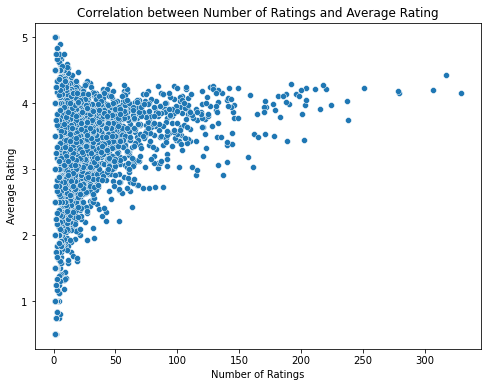

In [11]:
# Create a new dataframe with movie_id, number of ratings, and average rating
movie_stats = ratings.groupby('movieId').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['avg_rating', 'num_ratings']

# Plot correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(x='num_ratings', y='avg_rating', data=movie_stats)
plt.title('Correlation between Number of Ratings and Average Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()


PREPROCESSING

In [12]:
# One-hot encode genres for content-based filtering
movies_df['genres'] = movies_df['genres'].str.split('|')
movies_genres = movies_df['genres'].str.join('|').str.get_dummies()

# Combine movies and genres data
movies = pd.concat([movies_df[['movieId', 'title']], movies_genres], axis=1)

# Preprocess tags (merge tags for the same movie)
tags_grouped = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

# Merge tags with movies dataframe
movies = pd.merge(movies, tags_grouped, on='movieId', how='left')


MODELLING

COLLABORATIVE FILTERING

In [13]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Load data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Train-Test split
trainset, testset = train_test_split(data, test_size=0.2)

# Use SVD model
svd = SVD()

# Train the model
svd.fit(trainset)

# Make predictions and evaluate RMSE
predictions = svd.test(testset)
accuracy.rmse(predictions)


RMSE: 0.8761


0.8760920132646384

In [14]:
def recommend_movies_for_user(userId, num_recommendations=5):
    # Get a list of all movie IDs
    all_movie_ids = movies['movieId'].unique()
    
    # Get the list of movies already rated by the user
    rated_movies = ratings[ratings['userId'] == userId]['movieId'].unique()
    
    # Filter out movies the user has already rated
    unrated_movies = [movie for movie in all_movie_ids if movie not in rated_movies]
    
    # Predict ratings for unrated movies
    predictions = [svd.predict(userId, movieId) for movieId in unrated_movies]
    
    # Sort predictions by estimated rating
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:num_recommendations]
    
    # Get movie titles for the recommended movies
    recommended_movie_ids = [pred.iid for pred in top_predictions]
    recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
    
    return recommended_movies[['title']]


Creating a hybrid 